# Analyse brute des données quotidiennes publiques covid19  France et régions


[Dernier Rapport au format pdf sur le site github](https://github.com/grouss/COVID19France/raw/master/COVID19_France_Regions.pdf)

In [11]:
run -i function.py

In [ ]:
run -i load.py

## Chiffres des hospitalisations et des décès (Cumulés en France)

NameError: name 'data3' is not defined

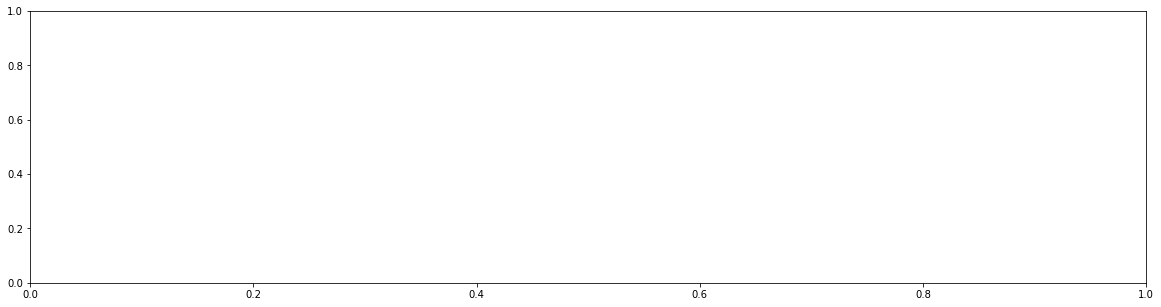

In [3]:
DisplayFrance()

## Chiffres des hospitalisations et des décès (par régions)

In [ ]:
for reg in region:
    DisplayRegions(reg)

## Chiffres des hospitalisations et des décès (par tranches d'age)

In [ ]:
for clage in trancheage:
    DisplayAge(clage)

In [6]:
CreateReport()
PushCommit()


# Sources de données

https://www.data.gouv.fr/fr/datasets/donnees-hospitalieres-relatives-a-lepidemie-de-covid-19/

# Méthodologie

- Traitement du fichier de données brutes.
- Représentation des moyennes hebdomadaires comme données de base lissées. 
- Affichage des différentes périodes de couvre-feu et confinement.
- Versionning du dépôt pour la traçabilité et la reproductibilité sur un dépôt public.
- Interface pour les commentaires via github.

# Quelques liens

- Euromomo (EuroMOMO is a European mortality monitoring activity, aiming to detect and measure excess deaths related to seasonal influenza, pandemics and other public health threats.)
https://www.euromomo.eu/graphs-and-maps/

- CépiDc (Centre d'épidémiologie sur les causes médicales de Décès)
https://opendata.idf.inserm.fr/cepidc/covid-19/index.html

- Avis de scientifiques CNRS, INSERM, Institut Pasteur, INRA, Université. Equipe bénévole et indépendante 
https://www.adioscorona.org/

- FranceInfo : "Suivez l’évolution de l'épidémie en France et dans le monde" 
https://www.francetvinfo.fr/sante/maladie/coronavirus/infographies-covid-19-morts-hospitalisations-age-malades-l-evolution-de-l-epidemie-en-france-et-dans-le-monde-en-cartes-et-graphiques.html

- le suivi des variants en angleterre https://www.gov.uk/government/publications/covid-19-variants-genomically-confirmed-case-numbers/

- Un exemple de modélisation épidémique par inférrence https://cloudapps.france-bioinformatique.fr/covidici/

# Quelques reférences bibliographiques
- "Evaluation des stratégies vaccinales COVID-19 avec un modèle mathématique populationnel" Cécile Kiem, Clément Massonnaud, Daniel Levy-Bruhl, Chiara Poletto, Vittoria Colizza, et al. 2020. [pasteur-03087143](https://hal.archives-ouvertes.fr/pasteur-03087143) (23/12/2020)
- "Evolution of outcomes for patients hospitalized during the first SARS-CoV-2 pandemic wave in France. 2020.", Noémie Lefrancq, Juliette Paireau, Nathanaël Hozé, Noémie Courtejoie, Yazdan Yazdanpanah, et al. [hal-02946545](https://hal.archives-ouvertes.fr/hal-02946545) (23/09/2020)
- "Seroprevalence of SARS-CoV-2 among adults in three regions of France following the lockdown and associated risk factors: a multicohort study." [Carrat et al. 2020](https://www.medrxiv.org/content/10.1101/2020.09.16.20195693v1)
- "Ready for a BASE jump? Do not neglect SARS-CoV-2 hospitalization and fatality risks in the middle-aged adult population" [Lapidus et al, 2020](https://www.medrxiv.org/content/10.1101/2020.11.06.20227025v1) (07/11/2020)
- "Estimated date of dominance of VOC-202012/01 strain in France and projected scenarios" [Sabbatini et al, 2021](http://www.epicx-lab.com/uploads/9/6/9/4/9694133/inserm_covid-19-voc_dominance-20210116.pdf) (All reports available [here](https://www.epicx-lab.com/covid-19.htm) )


## **Code Source et données**

- [function.py](function.py)
- [load.py](load.py)
- Données dans le repertoire local /RawData
